# Loading/cleaning/examining the City of Boston health inspections records
Source: [data.cityofboston.gov](https://data.cityofboston.gov/Health/Food-Establishment-Inspections/qndu-wx8w), with the dataset downloaded in CSV format to `data/Food_Establishment_Inspections.csv`

In [1]:
import pandas as pd
from numpy import nan
import numpy as np
import scipy.stats as stats
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
inspections = pd.read_csv(
    'data/Food_Establishment_Inspections.csv', 
    usecols = ['BusinessName', 'LICENSECAT',
       'DESCRIPT', 'RESULT', 'RESULTDTTM', 'Violation', 'ViolLevel',
       'ViolDesc', 'VIOLDTTM', 'ViolStatus', 'StatusDate', 'Comments', 'Address', 'City', 'State', 'Zip', 'Location'
    ],
    parse_dates = ['RESULTDTTM', 'VIOLDTTM', 'StatusDate'], 
    infer_datetime_format = True
)

# Rename variables for convenience:
inspections.columns = [
    'name',           # business name
    'category',       # business category ("FS", "FT", "RS", or "MFW")
    'type',           # more verbal description of business category 
    'result',         # result of the inspection (12 different possibilities)
    'result_date',    # date of inspection
    'violation',      # code for violation type
    'level',          # violation severity (can be * or ** or ***)
    'description',    # verbal description of violation
    'violation_date', # generally (or always?) the same as result_date
    'status',         # simply pass or fail
    'status_date',    # generally a day or so later than result_date, but often not given
    'comments',       # free-form text comments
    'address',
    'city',
    'state',
    'zip',
    'location'        # (latitude, longitude)
]

# Cut off any data from before August 1, 2011, since there are no 311 service records from before that time:
inspections = inspections[
    (inspections.result_date.astype(str) >= '2011-08-01') 
]

# Split the "location" data into separate latitude and longitude entries:
inspections['location'] = inspections.location.str.strip('()')
inspections[['latitude','longitude']] = inspections['location'].apply(lambda x: pd.Series(str(x).split(',')))
inspections['latitude'] = pd.to_numeric(inspections.latitude, errors='coerce')
inspections['longitude'] = pd.to_numeric(inspections.longitude, errors='coerce')

# Create a Google-searchable address for each establishment, so that those without latitude/longitude information
# can be filled in via the Google Maps Geocoding API, if desired:
inspections[['address']] = (
    inspections.address.fillna(inspections.name) + ', ' + inspections.city.fillna('Boston') + ', ' 
    + inspections.state.fillna('MA') + (' 0'+inspections.zip.fillna(0).astype(int).astype(str)).replace(' 00','')
)
inspections = inspections.drop(['city', 'state', 'zip', 'location'], 1)

In [3]:
# Take a look at the records for August 12, 2014:
inspections[
    inspections.result_date.astype(str).str.startswith('2014-08-12')
].sort_values(['name'])[[
        'name', 'category', 'result', 'level', 'description', 'comments', 'latitude', 'longitude'
    ]]

,name,category,result,level,description,comments,latitude,longitude
363935,A C Farm Market,RF,HE_Pass,**,Insects Rodents Animals,Evidence of fruit flies provide exterminators ...,42.302302,-71.059800
389871,A C Farm Market,RF,HE_Pass,*,Food Protection,Discontinue store vegetables in stagnant wate...,42.302302,-71.059800
372093,A C Farm Market,RF,HE_Pass,*,Dishwashng Facilities,Replace missing sink plugs.,42.302302,-71.059800
360435,A C Farm Market,RF,HE_Pass,*,Non-Food Contact Surfaces,Repair rusty shelving below prep table.,42.302302,-71.059800
374145,A C Farm Market,RF,HE_Pass,*,Food Container Labels,Provide labels for all packaged foods.,42.302302,-71.059800
147023,Choice's by Au Bon Pain,FT,HE_Fail,***,Cold Holding,salad bar/carrot and raisin salad 49 degrees/c...,NaN,NaN
146643,Choice's by Au Bon Pain,FT,HE_Fail,*,Equipment Thermometers,front line/ 2 door drawer/provide internal the...,NaN,NaN
144503,Choice's by Au Bon Pain,FT,HE_Fail,*,Improper Maintenance of Floors,replace damaged floor tile in front of proof b...,NaN,NaN
142939,Choice's by Au Bon Pain,FT,HE_Fail,*,Non-Food Contact Surfaces,bakery/replace worn door gasket to 1 door reac...,NaN,NaN
142060,Choice's by Au Bon Pain,FT,HE_Fail,*,Non-Food Contact Surfaces Clean,salad bar/clean interior cabinets,NaN,NaN


In [4]:
# Look at the records for August 12, 2014 in a more condensed form:
inspections[
    inspections.result_date.astype(str).str.startswith('2014-08-12')
].fillna('none').groupby([
        'name','type','result','level'
    ]).count()[['status']].rename(columns = {'status':'count'})

count
name                                           type                          result     level       
A C Farm Market                                Retail Food                   HE_Pass    *          4
                                                                                        **         1
Choice's by Au Bon Pain                        Eating & Drinking w/ Take Out HE_Fail    *          4
                                                                                        ***        1
City Sports                                    Retail Food                   HE_Fail    *          2
Convenient Corner                              Retail Food                   HE_Filed   *          1
DUNKIN DONUTS(FRANKLIN)                        Eating & Drinking w/ Take Out HE_Pass    none       1
Foumami                                        Eating & Drinking w/ Take Out HE_Pass    none       1
Great Chef                                     Eating & Drinking w/ Take Out HE_Pass    *          9
Harvard Stadium Stand No. 2                    Eating & Drinking w/ Take Out HE_Pass    none       1
KANTIN                                         Eating & Drinking w/ Take Out HE_Fail    *          3
                                                                                        ***        1
LOLLICUP TEA ZONE                              Eating & Drinking w/ Take Out HE_Fail    *          1
                                                                                        ***        1
Max Brenner                                    Eating & Drinking             HE_Fail    *         11
                                                                                        **         1
                                                                                        ***        3
Mcdonalds (Warren St.)                         Eating & Drinking w/ Take Out HE_Fail    *          2
                                                                                        ***        1
Mud House                                      Eating & Drinking             HE_Pass    *          2
                                                                                        ***        1
Nevilles Bakery & Restaurant                   Eating & Drinking w/ Take Out HE_FailExt *          8
                                                                                        **         1
Panera Bread Bakery Cafe                       Eating & Drinking             HE_Pass    *          5
                                                                                        ***        1
Pho Viets                                      Eating & Drinking w/ Take Out HE_Filed   *          1
Pollos A La Brasa Beto's                       Eating & Drinking w/ Take Out HE_Filed   *          7
Popeyes Chicken & Biscuit                      Eating & Drinking w/ Take Out HE_Fail    *          2
SOUTH BOSTON CHINESE                           Eating & Drinking w/ Take Out HE_Pass    *          4
                                                                                        **         1
                                                                                        ***        1
Samurai Kuang Eatery                           Eating & Drinking w/ Take Out HE_Pass    *          4
                                                                                        ***        1
Savory Food Truck No.  3 (P-33-235)            Mobile Food Walk On           HE_Filed   *          1
Shanghai Social Club                           Eating & Drinking             HE_Pass    *          2
                                                                                        **         1
                                                                                        ***        1
Shaw's Supermarket No. 586                     Retail Food                   HE_Fail    *          6
                                                       

In [5]:
# Find the number of businesses inspected, and the number that have ever failed:
len(
    inspections[
        inspections.result_date.astype(str) < '2015-06-25'
    ].name.unique()
), len(
    inspections[
        (inspections.result_date.astype(str) < '2015-06-25')
        & (inspections.status == 'Fail')
    ].name.unique()
)

(5604, 3876)

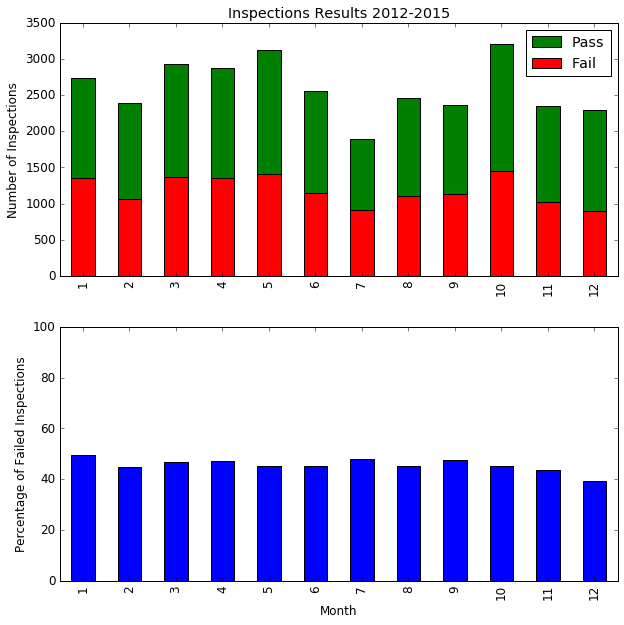

In [6]:
# To visualize patterns of inspections and failures in time...
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['font.size'] = 12
# In one bar chart, show all 2012-2015 inspections, broken down by month:
plt.subplot(2,1,1)
ax = inspections[
    (inspections.violation_date >= '2012-01-01 00:00:00') &
    (inspections.violation_date <= '2015-12-31 00:00:00')
].groupby(
    ['result_date', 'name']
).sum().reset_index('result_date').result_date.dt.month.value_counts().sort_index().plot(
    kind = 'bar', color='green'
)
# Also show the failed inspections:
inspections[
    (inspections.result.str.contains('Fail')) & 
    (inspections.violation_date >= '2012-01-01 00:00:00') &
    (inspections.violation_date <= '2015-12-31 00:00:00')
].groupby(
    ['result_date', 'name']
).sum().reset_index('result_date').result_date.dt.month.value_counts().sort_index().plot(
    kind = 'bar', ax = ax, color = 'red'
)
plt.title('Inspections Results 2012-2015')
plt.legend(['Pass','Fail'])
plt.ylabel('Number of Inspections')
# In another chart, show the 2012-2015 failure rate, broken down by month:
plt.subplot(2,1,2)
((
    (inspections[
            (inspections.result.str.contains('Fail')) & 
            (inspections.violation_date >= '2012-01-01 00:00:00') &
            (inspections.violation_date <= '2015-12-31 00:00:00')
        ].groupby(
                ['result_date', 'name']
            ).sum().reset_index('result_date').result_date.dt.month.value_counts().sort_index()) 
    / 
    (inspections[
            (inspections.violation_date >= '2012-01-01 00:00:00') &
            (inspections.violation_date <= '2015-12-31 00:00:00')
            ].groupby(
                ['result_date', 'name']
            ).sum().reset_index('result_date').result_date.dt.month.value_counts().sort_index())
)*100).plot(kind = 'bar', ylim=[0, 100])
plt.xlabel('Month')
plt.ylabel('Percentage of Failed Inspections')
None

In [7]:
# Find the number of businesses that have ever had rodent issues:
len(
    inspections[
        (inspections.result_date.astype(str) < '2015-06-25')
        & (inspections.description.str.contains('odent'))
    ].name.unique()
)

1236

# Loading/cleaning/examining the Yelp (condensed) health inspections records
Sources: [DrivenData.org](https://www.drivendata.org/competitions/5/page/17/) and [Yelp.com](https://www.yelp.com/dataset_challenge/drivendata), saving the datasets as
* `data/AllViolations.csv`
* `data/restaurant_ids_to_yelp_ids.csv`
* `data/yelp_academic_dataset_business.json`

In [8]:
# Load the inspections results data:
violations = pd.read_csv(
    'data/AllViolations.csv', 
    parse_dates = ['date'], 
    infer_datetime_format = True,
    index_col = 0
)

In [9]:
# Convert the file of businesses' details to a proper JSON string:
import json
with open('data/yelp_academic_dataset_business.json', 'r') as f:
    data = f.readlines()
data = map(lambda x: x.rstrip(), data)
data_json_str = '[' + (',').join(data) + ']'

# Convert the string to a dataframe:
business = pd.read_json(data_json_str)
business = business[[
    'name',
    'full_address',
    'city',
    'business_id',
    'latitude',
    'longitude'
]]

# Rename the variables for convenience:
business.columns = [
    'name',     
    'address',
    'city',
    'yelp_id',
    'latitude',
    'longitude'
]

# Dump the intermediate data used to produce the business details dataframe:
%reset_selective -f data_json_str
%reset_selective -f data

In [10]:
# Load the table for converting between "ID" systems:
idtable = pd.read_csv(
    'data/restaurant_ids_to_yelp_ids.csv'
)

# Reshape the table for easier use:
idtable = pd.concat([
        idtable[['restaurant_id','yelp_id_0']].rename(columns = {'yelp_id_0':'yelp_id'}),
        idtable[idtable.yelp_id_1.notnull()][['restaurant_id','yelp_id_1']].rename(columns = {'yelp_id_1':'yelp_id'}),
        idtable[idtable.yelp_id_2.notnull()][['restaurant_id','yelp_id_2']].rename(columns = {'yelp_id_2':'yelp_id'}),
        idtable[idtable.yelp_id_3.notnull()][['restaurant_id','yelp_id_3']].rename(columns = {'yelp_id_3':'yelp_id'})
], ignore_index = True)

In [11]:
# Combine the datasets to provide each inspected business with latitude/longitude information:
violations = violations.merge(
    idtable, 
    on = 'restaurant_id'
).merge(
    business, 
    on = 'yelp_id'
).drop(['yelp_id', 'address', 'city'], 1)

# As before, cut off any records before August 1, 2011:
violations = violations[violations.date >= '2011-08-01']

In [12]:
# Take a look at the records for August 12, 2014:
violations[violations.date == '2014-08-12'].sort_values('name')

,date,restaurant_id,*,**,***,name,latitude,longitude
8004,2014-08-12,we39j9ok,4,0,0,Dunkin' Donuts,42.349264,-71.042474
20155,2014-08-12,lnORdd3N,0,0,0,Dunkin' Donuts,42.356527,-71.053353
33990,2014-08-12,KAoK8ZOg,0,0,0,Fóumami,42.356039,-71.053455
7757,2014-08-12,0ZEDGWOD,9,0,0,Great Chef Chinese Food Day Square,42.379525,-71.027940
1423,2014-08-12,njoZ1D3r,3,0,1,Kantin,42.352744,-71.125447
2566,2014-08-12,eVOBLr3j,1,0,1,Lollicup,42.352444,-71.125403
35075,2014-08-12,B1oXNlEV,11,1,3,Max Brenner,42.349491,-71.080588
25898,2014-08-12,B1oX4boV,4,0,1,Samurai Kuang Eatery,42.355741,-71.058335
28452,2014-08-12,8xExZeo0,4,1,1,South Boston Chinese Restaurant,42.336483,-71.047309


In [13]:
# Find the number of businesses inspected, and the number that have ever failed:
len(
    violations[
        violations.date.astype(str) < '2015-06-25'
    ].name.unique()
), len(
    violations[
        (violations.date.astype(str) < '2015-06-25')
        & (violations['*'] + violations['**'] + violations['***'] > 0)
    ].name.unique()
)

(1634, 1327)

# Loading/cleaning/examining the service request call records
Source: [data.cityofboston.gov](https://data.cityofboston.gov/City-Services/311-Service-Requests/awu8-dc52), with the dataset downloaded in CSV format to `data/311__Service_Requests.csv`

In [14]:
services = pd.read_csv(
    'data/311__Service_Requests.csv', 
    usecols = [
       'OPEN_DT', 'CLOSED_DT', 'CASE_STATUS', 'CLOSURE_REASON', 'CASE_TITLE', 'SUBJECT', 'REASON',
       'TYPE', 'LATITUDE', 'LONGITUDE'
    ],
    parse_dates=['OPEN_DT', 'CLOSED_DT'], 
    infer_datetime_format = True
)

# Rename variables for convenience:
services.columns = [
    'open',         # date the complaint was registered
    'closed',       # date the complaint was resolved
    'status',       # open or closed
    'closure',      # details of how the complaint was closed (NaN if open)
    'title',        # description of the issue
    'subject',      # category of the issue (e.g. public works, civil rights, animal control, etc.)
    'reason',       # more specific category (often very similar to the "title")
    'type',         # usually identical to the "title" 
    'latitude',      
    'longitude'      
]
services = services.sort_values(['open', 'reason'])

# Take a look at a few randomly-selected service calls:
services.sample(10)

,open,closed,status,closure,title,subject,reason,type,latitude,longitude
703638,2016-02-22 13:45:00,2016-02-22 18:38:17,Closed,Case Closed. Closed date : 2016-02-22 18:38:17...,Empty Litter Basket,Public Works Department,Highway Maintenance,Empty Litter Basket,42.3594,-71.0587
18986,2013-07-10 09:17:52,2013-07-10 09:59:27,Closed,Case Closed Case Resolved inspected and found ...,Pick up Dead Animal,Public Works Department,Street Cleaning,Pick up Dead Animal,42.3503,-71.0489
537851,2015-09-02 09:39:00,2015-09-09 11:52:45,Closed,Case Closed. Closed date : 2015-09-09 11:52:45...,Sign Repair,Transportation - Traffic Division,Signs & Signals,Sign Repair,42.3322,-71.1069
548725,2015-02-18 06:13:03,2015-03-27 14:16:33,Closed,Case Closed Case Resolved,Request for Snow Plowing,Public Works Department,Street Cleaning,Request for Snow Plowing,42.2731,-71.0782
121199,2014-03-04 11:36:15,2014-03-10 16:02:42,Closed,Case Closed Case Resolved This request has bee...,Recycling Cart Inquiry,Public Works Department,Recycling,Recycling Cart Inquiry,42.3707,-71.0376
420604,2013-12-17 19:26:59,2013-12-18 02:51:42,Closed,Case Closed Case Resolved plowed,Request for Snow Plowing,Public Works Department,Street Cleaning,Request for Snow Plowing,42.2869,-71.1621
389644,2012-10-29 11:52:37,NaT,Open,NaN,Heat - Excessive Insufficient,Inspectional Services,Housing,Heat - Excessive Insufficient,42.3455,-71.1442
144348,2013-07-29 10:32:25,2013-07-29 12:23:57,Closed,Case Closed Case Resolved,Requests for Street Cleaning,Public Works Department,Street Cleaning,Requests for Street Cleaning,42.3388,-71.0762
699143,2016-02-08 15:48:00,2016-02-17 16:30:27,Closed,Case Closed. Closed date : 2016-02-17 16:30:27...,Schedule a Bulk Item Pickup,Public Works Department,Sanitation,Schedule a Bulk Item Pickup,42.2937,-71.0781
602573,2015-01-22 18:31:57,NaT,Open,NaN,Graffiti Removal,Property Management,Graffiti,Graffiti Removal,42.3594,-71.0587


In [15]:
# Count how many different titles, subjects, reasons, and types there are:
(
    len(services.title.unique()), 
    len(services.subject.unique()), 
    len(services.reason.unique()), 
    len(services.type.unique())
)

(7837, 18, 61, 215)

In [16]:
# Retrieve a list of the various "reasons" that have been used for service calls, sorted by prevalence:
reason = services.reason.value_counts().reset_index()

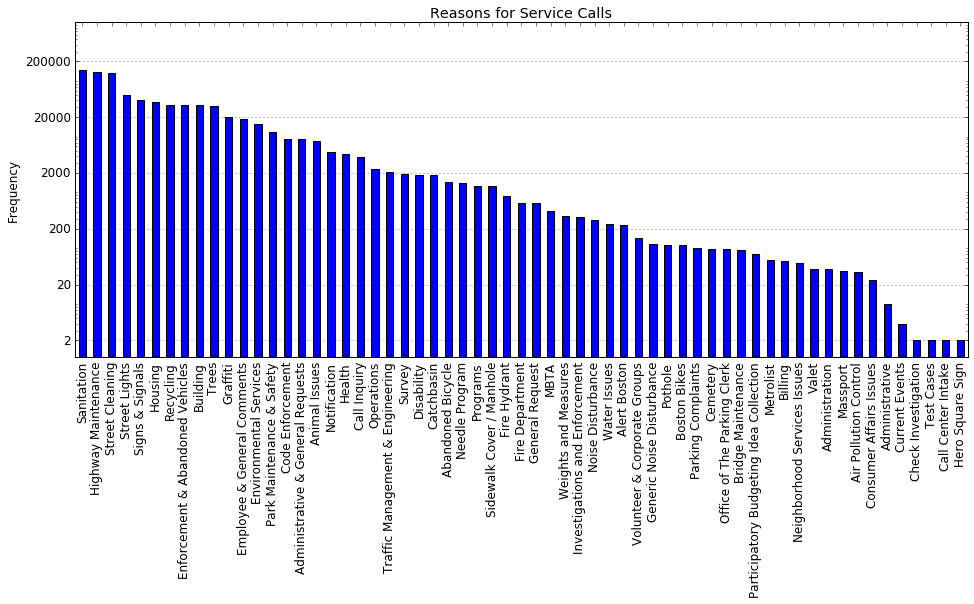

In [17]:
# Plot the prevalences of the service call reasons:
plt.rcParams['figure.figsize'] = (16, 6)
plt.rcParams['font.size'] = 12
ax = reason.plot(kind = 'bar', log = True)
ax.set_xticklabels(reason['index'])
ax.set_yticks([2,20,200,2000,20000,200000])
ax.set_yticklabels([2,20,200,2000,20000,200000])
ax.legend_.remove()
ax.grid(axis = 'y')
ax.set_title('Reasons for Service Calls')
ax.set_ylabel('Frequency')
None

In [18]:
# Store only the names of the top 54 reasons for later use:
reason = reason.head(54)['index']

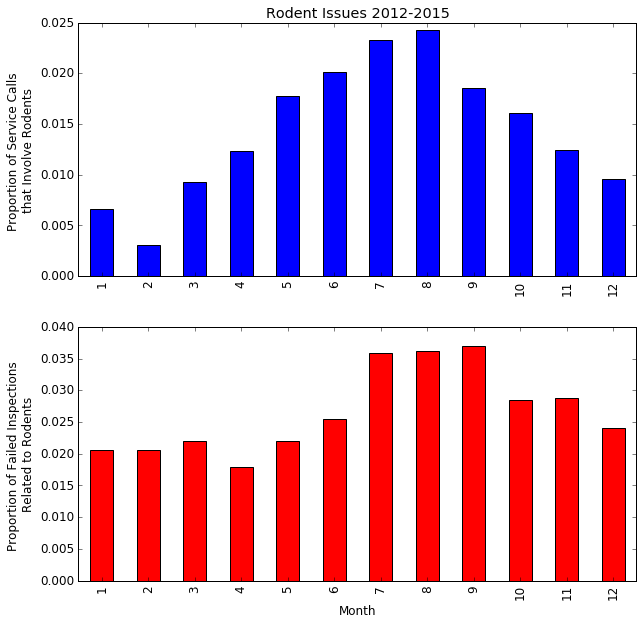

In [19]:
# To visualize the yearly patterns of rodent issues...
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['font.size'] = 12
# Show the frequency of rodent-related service calls from month to month:
plt.subplot(2,1,1)
(
    services[
        (services.title.fillna('').str.contains('odent')) &
        (services.open >= '2012-01-01 00:00:00') &
        (services.open <= '2015-12-31 00:00:00')
    ].open.dt.month.value_counts().sort_index()
    /
    services[
        (services.open >= '2012-01-01 00:00:00') &
        (services.open <= '2015-12-31 00:00:00')
    ].open.dt.month.value_counts().sort_index()
).plot(kind = 'bar')
plt.ylabel('Proportion of Service Calls \nthat Involve Rodents')
plt.title('Rodent Issues 2012-2015')
# Show the frequency of rodent-related inspection issues from month to month:
plt.subplot(2,1,2)
(
    (inspections[
            (inspections.result.str.contains('Fail')) & 
            (inspections.violation_date >= '2012-01-01 00:00:00') &
            (inspections.violation_date <= '2015-12-31 00:00:00') &
            (inspections.description.str.contains('odent'))
        ].result_date.dt.month.value_counts().sort_index()) 
    / 
    (inspections[
            (inspections.result.str.contains('Fail')) & 
            (inspections.violation_date >= '2012-01-01 00:00:00') &
            (inspections.violation_date <= '2015-12-31 00:00:00') 
        ].result_date.dt.month.value_counts().sort_index())
).plot(kind = 'bar', color='red')
plt.xlabel('Month')
plt.ylabel('Proportion of Failed Inspections \nRelated to Rodents')
None

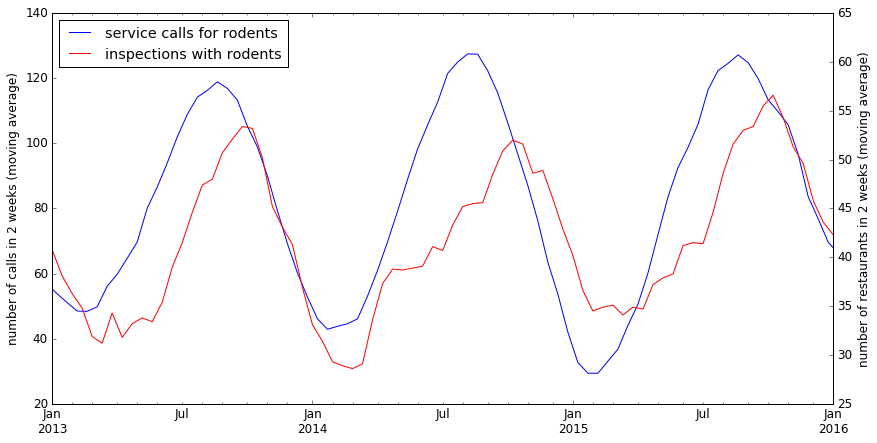

In [20]:
# This is basically a different take on the visualization above
# (but not used in final version of report):
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['font.size'] = 12
ax = services[services.title.fillna('').str.contains('odent')].set_index(
    'open'
)[['status']].rename(columns = {'status':'service calls for rodents'}).resample('2w').count().fillna(0).rolling(
    window=10, min_periods=1, center=True
).mean().plot(
    kind='line', 
    xlim=['2013-01-01 00:00:00','2015-12-31 00:00:00']
)
plt.ylabel('number of calls in 2 weeks (moving average)')
inspections[inspections.description.fillna('').str.contains('odent')].set_index(
    'result_date'
)[['status']].rename(columns = {'status':'inspections with rodents'}).resample('2w').count().fillna(0).rolling(
    window=10, min_periods=1, center=True
).mean().plot(
    kind='line', 
    xlim=['2013-01-01 00:00:00','2015-12-31 00:00:00'],
    ax = ax, 
    sharex = True, 
    secondary_y = True, 
    mark_right = False,
    c = 'red'
)
plt.ylabel('number of restaurants in 2 weeks (moving average)')
ax.set_xlabel('')
None

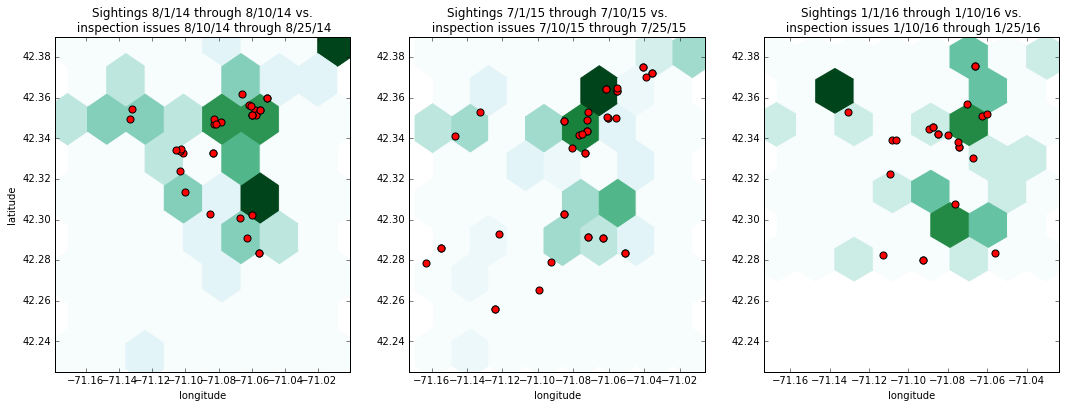

In [21]:
# To visualize spatial patterns of rodent issues...
plt.rcParams['figure.figsize'] = (18, 6)
plt.rcParams['font.size'] = 10
# Plot the geographical distribution of rodent-related service requests in a certain time period:
ax = plt.subplot(1,3,3)
services[
    (services.title.fillna('').str.contains('odent')) &
    ('2016-01-01 00:00:00' <= services.open) &
    (services.open <= '2016-01-10 00:00:00')
].plot.hexbin(x='longitude',y='latitude',gridsize=[7,3],colorbar=False,ax=ax,ylim=[42.225,42.39])
# Show the locations of all inspections with mentions of rodents in a subsequent time period:
inspections[
    (inspections.description.fillna('').str.contains('odent')) &
    ('2016-01-10 00:00:00' <= inspections.result_date) &
    (inspections.result_date <= '2016-01-25 00:00:00')
].plot(x='longitude',y='latitude',kind='scatter',ax=ax,color='red', s=50)
plt.ylabel('')
ax.set_title('Sightings 1/1/16 through 1/10/16 vs.\n inspection issues 1/10/16 through 1/25/16')

# Repeat the steps above for a second period of time:
ax = plt.subplot(1,3,2)
services[
    (services.title.fillna('').str.contains('odent')) &
    ('2015-07-01 00:00:00' <= services.open) &
    (services.open <= '2015-07-10 00:00:00')
].plot.hexbin(x='longitude',y='latitude',gridsize=7,colorbar=False, ax=ax,ylim=[42.225,42.39])
inspections[
    (inspections.description.fillna('').str.contains('odent')) &
    ('2015-07-10 00:00:00' <= inspections.result_date) &
    (inspections.result_date <= '2015-07-25 00:00:00')
].plot(x='longitude',y='latitude',kind='scatter',ax=ax,color='red', s=50)
plt.ylabel('')
ax.set_title('Sightings 7/1/15 through 7/10/15 vs.\n inspection issues 7/10/15 through 7/25/15')

# Repeat the steps above for a third period of time:
ax = plt.subplot(1,3,1)
services[
    (services.title.fillna('').str.contains('odent')) &
    ('2014-08-01 00:00:00' <= services.open) &
    (services.open <= '2014-08-10 00:00:00')
].plot.hexbin(x='longitude',y='latitude',gridsize=7,colorbar=False,ax=ax,ylim=[42.225,42.39])
inspections[
    (inspections.description.fillna('').str.contains('odent')) &
    ('2014-08-10 00:00:00' <= inspections.result_date) &
    (inspections.result_date <= '2014-08-25 00:00:00')
].plot(x='longitude',y='latitude',kind='scatter',ax=ax,color='red', s=50)
ax.set_title('Sightings 8/1/14 through 8/10/14 vs.\n inspection issues 8/10/14 through 8/25/14')
None

In [22]:
# Determine which reason(s) correspond(s) to rodent sightings:
services[services.title.fillna('').str.contains('odent')].reason.value_counts()

Environmental Services    10677
Highway Maintenance           1
Street Lights                 1
Name: reason, dtype: int64

In [23]:
# Determine what kinds of issues are categorized under the "Environmental Services" reason:
services[services.reason == 'Environmental Services'].title.value_counts()

Rodent Activity                           10677
Overflowing or Un-kept Dumpster            1567
Trash on Vacant Lot                        1320
Abandoned Building                          641
Illegal Auto Body Shop                      415
Pigeon Infestation                          184
Mosquitoes (West Nile)                       80
Rat Bite                                     55
Removal of un-maintained litter basket        1
City-owned Lots/Properties                    1
Name: title, dtype: int64

In [24]:
# Dump the "inspections" dataframe, since it won't be used for anything going forward:
%reset_selective -f inspections

# Extracting features

In [25]:
# Suppress "chained assignment" warnings:
pd.options.mode.chained_assignment = None

# Create empty columns for each of the "reasons":
for j in range(len(reason)):
    violations[reason[j]] = nan

# Create an empty "delay" column:
violations['delay'] = nan

# Get the integer positions of the reason columns:
reasoncols = reason.apply(violations.columns.get_loc)

# Fill in the new columns, row-by-row:
for row in range(len(violations)):
    # Location of current inspection:
    c = (violations.latitude.iloc[row], violations.longitude.iloc[row])
    # Restaurant ID of current inspection:
    ri = violations.restaurant_id.iloc[row]
    # Date of current inspection:
    t = violations.date.iloc[row]
    # Date of most recent previous inspection of current restaurant:
    tlast = violations[(violations.date <= t - timedelta(days = 1)) & (violations.restaurant_id == ri)].date.max()
    # Calculate the "delay" (time elapsed since last inspection):
    violations['delay'].iloc[row] = t - tlast
    # Get all service calls near the current restaurant in the recent past:
    s = services[
            (services.open < t - timedelta(days = 5)) &
            (services.open > t - timedelta(days = 15)) &
            ((services.latitude - c[0])**2 + (5/7*(services.longitude - c[1]))**2 < 0.0025)
    ]
    # Count and record the number of times each "reason" occurred:
    violations.iloc[row, reasoncols] = s.groupby('reason').count().iloc[:,0][reason].fillna(0).values

# Convert the "delays" to raw numbers (rather than datetime objects):
violations['delay'] = (violations.delay) / (timedelta(days=1))
violations['delay'] = violations.delay.astype(float)

In [26]:
# Take a look at one particular day of features and targets:
violations[violations.date == '2014-07-22'].drop(['restaurant_id','latitude','longitude'], 1)

,date,*,**,***,name,Sanitation,Highway Maintenance,Street Cleaning,Street Lights,Signs & Signals,...,Bridge Maintenance,Participatory Budgeting Idea Collection,Metrolist,Billing,Neighborhood Services Issues,Valet,Administration,Massport,Air Pollution Control,delay
802,2014-07-22,13,0,0,My Thai Vegan Cafe,587.0,382.0,137.0,172.0,148.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,204.0
1014,2014-07-22,8,0,1,Penguin Pizza,699.0,455.0,180.0,191.0,193.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,208.0
3114,2014-07-22,0,0,0,Rebecca's Cafe,521.0,318.0,114.0,165.0,134.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,194.0
9951,2014-07-22,22,2,12,New Saigon Sandwich,587.0,384.0,137.0,172.0,150.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,186.0
11026,2014-07-22,10,2,2,Teriyaki House,616.0,395.0,168.0,172.0,158.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,11.0
11783,2014-07-22,35,2,11,Xinh Xinh,586.0,382.0,137.0,172.0,148.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
12117,2014-07-22,5,0,0,Restaurante Cesaria,728.0,427.0,222.0,131.0,165.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,7.0
12574,2014-07-22,6,2,2,Anh Hong,669.0,359.0,210.0,86.0,131.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,166.0
20419,2014-07-22,3,0,0,Starbucks,628.0,408.0,148.0,178.0,172.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,148.0
27566,2014-07-22,9,2,1,Al Dente Restaurant,444.0,304.0,101.0,156.0,122.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,140.0


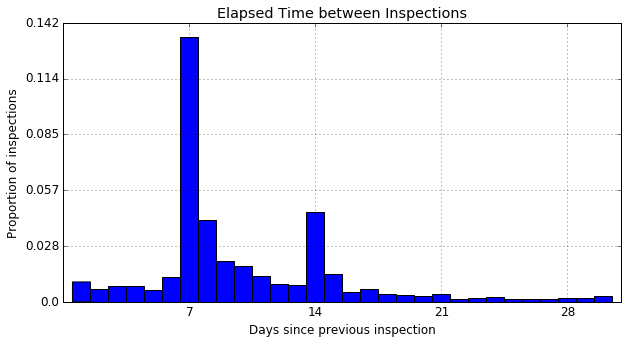

In [27]:
# To visualize the timing of inspections that take place within a month of their predecessors...
# Set the size of the graph:
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['font.size'] = 12
# Create a histogram:
ax = violations.delay.hist(bins=range(1, 32), align='left')
ax.set_xlim([0,31])
ax.set_xticks([7,14,21,28])
# Show proportions rather than raw counts on the "y" axis:
ax.set_yticklabels(np.round(ax.get_yticks()/len(violations),3))
# Labeling:
ax.set_xlabel('Days since previous inspection')
ax.set_ylabel('Proportion of inspections')
ax.set_title('Elapsed Time between Inspections')
None

# Inference
Some of the following code is adapted from [Allen Downey's ``HypothesisTest`` class](https://github.com/AllenDowney/CompStats/blob/master/hypothesis.ipynb).

In [50]:
class HypothesisTest(object):
    """Represents a hypothesis test."""

    def __init__(self, data):
        """Initializes.

        data: data in whatever form is relevant
        """
        self.data = data
        self.MakeModel()
        self.actual = self.TestStatistic(data)
        self.test_stats = None

    def PValue(self, iters=1000):
        """Computes the distribution of the test statistic and p-value.

        iters: number of iterations

        returns: float p-value
        """
        self.test_stats = np.array([self.TestStatistic(self.RunModel()) 
                                       for _ in range(iters)])

        count = sum(self.test_stats >= self.actual)
        return count / iters

    def MaxTestStat(self):
        """Returns the largest test statistic seen during simulations.
        """
        return max(self.test_stats)

    def TestStatistic(self, data):
        """Computes the test statistic.

        data: data in whatever form is relevant        
        """
        raise UnimplementedMethodException()

    def MakeModel(self):
        """Build a model of the null hypothesis.
        """
        pass

    def RunModel(self):
        """Run the model of the null hypothesis.

        returns: simulated data
        """
        raise UnimplementedMethodException()


class DiffPropsPermute(HypothesisTest):
    """Tests a difference in proportions by permutation."""

    def TestStatistic(self, data):
        """Computes the test statistic.

        data: data in whatever form is relevant        
        """
        group1, group2 = data
        test_stat = abs(sum(group1)/len(group1) - sum(group2)/len(group2))
        return test_stat

    def MakeModel(self):
        """Build a model of the null hypothesis.
        """
        group1, group2 = self.data
        self.n, self.m = len(group1), len(group2)
        self.pool = np.hstack((group1, group2))

    def RunModel(self):
        """Run the model of the null hypothesis.

        returns: simulated data
        """
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data

In [53]:
# Show the average number of "environmental services" complaints near inspected businesses:
violations['Environmental Services'].mean(), violations['Environmental Services'].median()

(43.788745229822865, 38.0)

In [54]:
# Test whether businesses near more than 10 "environmental services" complaints have 
# a different rate of inspection failure than others:
set1 = violations[(violations.delay > 14) & (violations['Environmental Services'] < 10)][['*','**','***']]
set2 = violations[(violations.delay > 14) & (violations['Environmental Services'] >= 10)][['*','**','***']]
data1 = (set1['*'] + set1['**'] + set1['***'] > 0)
data2 = (set2['*'] + set2['**'] + set2['***'] > 0)
ht_data = (data1, data2)
ht = DiffPropsPermute(ht_data)
# Display the sample difference in proportions and the p-value:
(ht.TestStatistic(ht_data), ht.PValue(iters = 1000))

(0.2000965815894642, 0.0)

In [56]:
# Determine what kinds of issues are categorized under the "health" reason:
services[services.reason == 'Health'].title.value_counts()

Unsanitary Conditions - Establishment                             1942
Unsanitary Conditions - Food                                      1046
Food Alert - Unconfirmed                                           531
Food Alert - Confirmed                                             402
Unsanitary Conditions - Employees                                  220
Fire in Food Establishment                                         128
No Utilities - Food Establishment - Water                           32
No Utilities - Food Establishment - Sewer                           29
No Utilities - Food Establishment - Electricity                     21
No Utilities - Food Establishment - Flood                           18
Boston Public Health Commission (BPHC)                               1
ONS - Boston Public Health Commission (BPHC) Hording Situation       1
Name: title, dtype: int64

In [57]:
# Show the average number of "health" complaints near inspected businesses:
violations['Health'].mean(), violations['Health'].median()

(14.801161929714644, 15.0)

In [58]:
# Test whether businesses near more than 3 "health" complaints have 
# a different rate of inspection failure than others:
set1 = violations[(violations.delay > 14) & (violations['Health'] < 3)][['*','**','***']]
set2 = violations[(violations.delay > 14) & (violations['Health'] >= 3)][['*','**','***']]
data1 = (set1['*'] + set1['**'] + set1['***'] > 0)
data2 = (set2['*'] + set2['**'] + set2['***'] > 0)
ht_data = (data1, data2)
ht = DiffPropsPermute(ht_data)
# Display the sample difference in proportions and the p-value:
(ht.TestStatistic(ht_data), ht.PValue(iters = 1000))

(0.26586861044163224, 0.0)

# Building Models

In [28]:
# To finalize the features and targets that predictive models will use...
# Cut all re-inspections out of the data and randomize the order of the dataset:
violations_ = violations[violations.delay > 14].sample(frac = 1)
# Make room for three last model features:
violations_['last1'] = nan   # The number of one-star violations found at the last inspection
violations_['last2'] = nan   # The number of two-star violations found at the last inspection.
violations_['last3'] = nan   # The number of three-star violations found at the last inspection.
# Fill in the new features, row-by-row:
for row in range(len(violations_)):
    # Get the current inspection's restaurant ID:
    ri = violations_.restaurant_id.iloc[row]
    # Get the date of the current inspection:
    t = violations_.date.iloc[row]
    # Get the details from the previous inspections of this restaurant, with the most recent first:
    last = violations_[
        (violations_.date <= t - timedelta(days = 1)) &
        (violations_.restaurant_id == ri)
    ].sort_values('date', ascending = False)
    # If there even was a previous inspection, record the violation counts:
    if len(last) > 0:
        violations_['last1'].iloc[row] = last['*'].iloc[0]
        violations_['last2'].iloc[row] = last['**'].iloc[0]
        violations_['last3'].iloc[row] = last['***'].iloc[0]
# Build the features matrix, filling in zero previous violations for any restaurant with no previous inspection: 
X = violations_.drop([
        'date', 'restaurant_id', '*', '**', '***', 'name'
    ],1).fillna(0)
# Build the targets vector ("1" for failed inspections, "0" for passed):
y = (violations_['*'] + violations_['**'] + violations_['***'] > 0).values.astype(np.int)

In [29]:
# View the number of samples and features:
X.shape

(9641, 60)

In [30]:
# View the proportion of targets that are failed:
sum(y)/len(y)

0.65677834249559175

In [32]:
# To build a support vector machine classifier (SVC)...
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.grid_search import GridSearchCV
import warnings

# Prepare training and test data:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=.8, stratify = y)

# Standardize the training features:
scaler = StandardScaler()
Xtrain = scaler.fit_transform(Xtrain)

# Search (with cross-validation) for the best hyperparameters for the SVC:
gs = GridSearchCV(
        estimator = SVC(probability = True),
        param_grid = {
            'C' : np.logspace(-1, 1, 5),
            'gamma' : np.logspace(-4, 0, 9),
        },
        # Use all available cores:
        n_jobs = -1
)
# Suppress an erroneous warning
# (see https://github.com/scikit-learn/scikit-learn/issues/6370):
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    gs.fit(Xtrain, ytrain)

# Save the best SVC that was found:
clf_SVM = gs.best_estimator_

# Display the best hyperparameters:
gs.best_params_

{'C': 1.0, 'gamma': 0.031622776601683791}

In [33]:
# Show the accuracy on the training and test sets:
clf_SVM.score(Xtrain, ytrain), clf_SVM.score(scaler.transform(Xtest), ytest)

(0.87227697095435686, 0.86780715396578534)

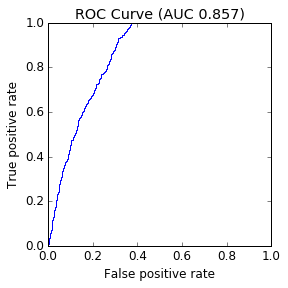

In [34]:
# Display the ROC curve and calculate the AUC:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
plt.rcParams['figure.figsize'] = (4, 4)
plt.rcParams['font.size'] = 12
xroc, yroc, _ = roc_curve(ytest, clf_SVM.predict_proba(scaler.transform(Xtest))[:,1])
plt.plot(xroc, yroc)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve (AUC ' + str(round(auc(xroc,yroc), 3)) + ')')
plt.show()

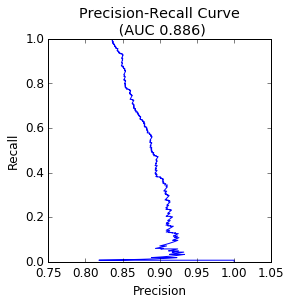

In [35]:
# Show the precision-recall curve and its AUC:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
xprc, yprc, _ = precision_recall_curve(ytest, clf_SVM.predict_proba(scaler.transform(Xtest))[:,1])
plt.plot(xprc, yprc)
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Precision-Recall Curve\n (AUC ' + str(round(
            average_precision_score(ytest, clf_SVM.predict_proba(scaler.transform(Xtest))[:,1]), 3)) + ')')
plt.show()

C:\Users\Science\Anaconda3\lib\site-packages\sklearn\externals\joblib\hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


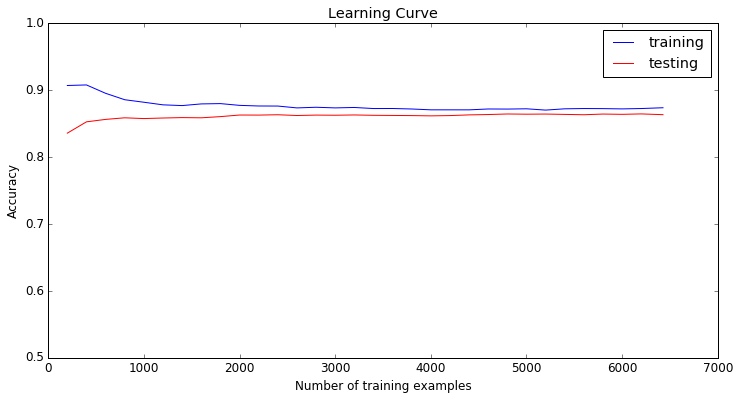

In [36]:
# Create the learning curve:
from sklearn.learning_curve import learning_curve
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

train_size, train_score, test_score = learning_curve(
    clf_SVM, 
    scaler.transform(X), 
    y, 
    n_jobs = -1,
    train_sizes = np.hstack((np.arange(200, 6400, 200), 6427))
)
plt.plot(
    train_size, 
    train_score.mean(axis = 1), 
    label='training'
)
plt.plot(
    train_size, 
    test_score.mean(axis = 1), 
    label='testing', c='red'
)
plt.legend(loc = 0)
plt.ylim([0.5, 1])
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.show()

In [37]:
# To build a random forest classifier...
from sklearn.ensemble import RandomForestClassifier

# Prepare training and test data:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=.8, stratify = y)

# Search (with cross-validation) for the best hyperparameters:
gs = GridSearchCV(
        estimator = RandomForestClassifier(n_estimators = 800),
        param_grid = {
            'max_depth' : [None, 5, 15],
            'max_features' : np.arange(5, 10, 1),
            'min_samples_leaf' : np.arange(1, 9, 1),
            'min_samples_split' : np.arange(1, 9, 1),
        },
        # Use all cores:
        n_jobs = -1
)
gs.fit(Xtrain, ytrain)

# Save the best random forest that was found:
clf_RF = gs.best_estimator_

# Display the best hyperparameters:
gs.best_params_

{'max_depth': None,
 'max_features': 6,
 'min_samples_leaf': 3,
 'min_samples_split': 2}

In [38]:
# Show the accuracy on the training and test sets:
clf_RF.score(Xtrain, ytrain), clf_RF.score(Xtest, ytest)

(0.93399896265560167, 0.87558320373250387)

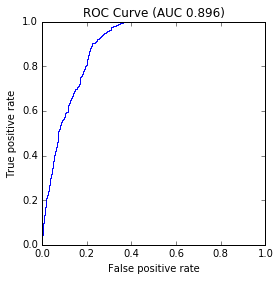

0.89573343316395504

In [39]:
# Graph the ROC curve and find the AUC:
plt.rcParams['figure.figsize'] = (4, 4)
plt.rcParams['font.size'] = 12
xroc, yroc, _ = roc_curve(ytest, clf_RF.predict_proba(Xtest)[:,1])
plt.plot(xroc, yroc)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve (AUC ' + str(round(auc(xroc,yroc), 3)) + ')')
plt.show()
auc(xroc,yroc)

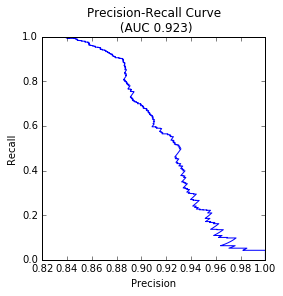

In [40]:
# Display the precision-recall curve and its AUC:
xprc, yprc, _ = precision_recall_curve(ytest, clf_RF.predict_proba(Xtest)[:,1])
plt.plot(xprc, yprc)
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Precision-Recall Curve\n (AUC ' + str(round(
            average_precision_score(ytest, clf_RF.predict_proba(Xtest)[:,1]), 3)) + ')')
plt.show()

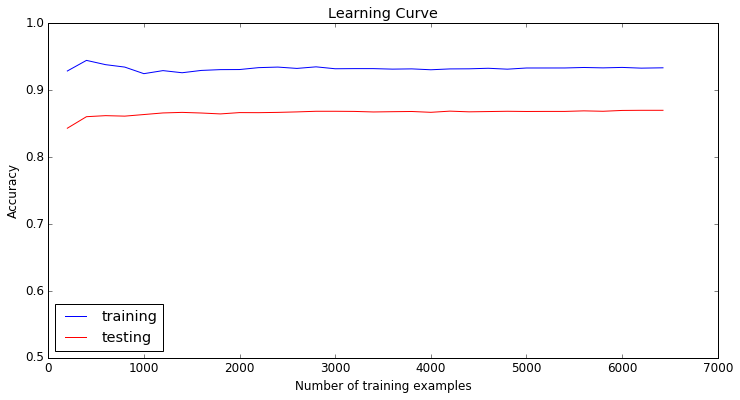

In [41]:
# Show the learning curve:
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

train_size, train_score, test_score = learning_curve(
    clf_RF, 
    X, 
    y, 
    n_jobs = -1,
    train_sizes = np.hstack((np.arange(200, 6400, 200), 6427))
)
plt.plot(
    train_size, 
    train_score.mean(axis = 1), 
    label='training'
)
plt.plot(
    train_size, 
    test_score.mean(axis = 1), 
    label='testing', c='red'
)
plt.legend(loc = 0)
plt.ylim([0.5,1])
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.show()

In [42]:
# Find the importances of the features, and list them in order of descending importance:
featurelist = pd.DataFrame()
featurelist['name'] = X.columns
featurelist['importance'] = clf_RF.feature_importances_
featurelist.sort_values('importance', ascending = False)

,name,importance
11,Trees,0.100893
3,Highway Maintenance,0.077976
8,Recycling,0.052335
10,Building,0.048371
14,Environmental Services,0.044653
23,Traffic Management & Engineering,0.039792
12,Graffiti,0.036057
20,Health,0.035515
4,Street Cleaning,0.033118
35,Weights and Measures,0.032445


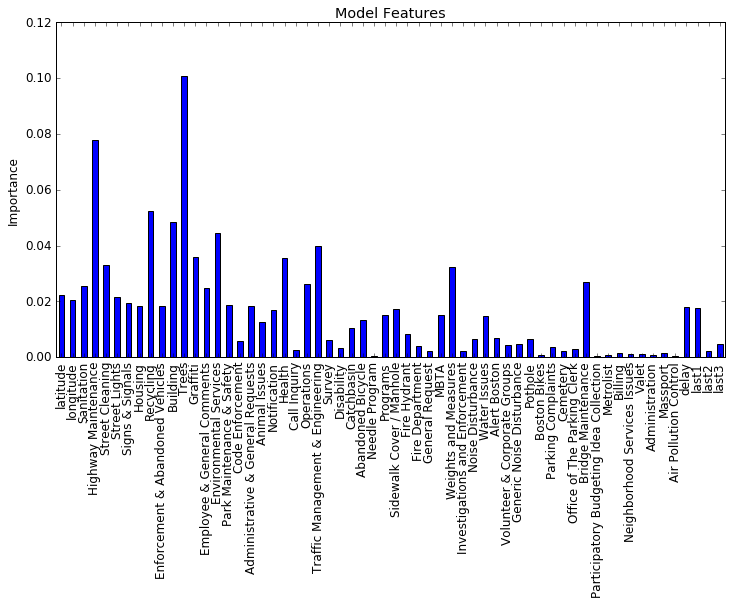

In [43]:
# Visualize the importances:
ax = featurelist.plot(kind='bar')
ax.set_xticklabels(featurelist['name'])
ax.legend_.remove()
ax.set_title('Model Features')
ax.set_ylabel('Importance')
None

# Comparison to DrivenData Contest

In [10]:
# Create a new set of features, very similar to the others, but for fairness,
# use EVERY reported inspection result (including the mislabeled re-inspections):
violations__ = violations.sample(frac = 1)
violations__['last1'] = nan
violations__['last2'] = nan
violations__['last3'] = nan
for row in range(len(violations__)):
    ri = violations__.restaurant_id.iloc[row]
    t = violations__.date.iloc[row]
    last = violations__[
        (violations__.date <= t - timedelta(days = 1)) &
        (violations__.restaurant_id == ri)
    ].sort_values('date', ascending = False)
    if len(last) > 0:
        violations__['last1'].iloc[row] = last['*'].iloc[0]
        violations__['last2'].iloc[row] = last['**'].iloc[0]
        violations__['last3'].iloc[row] = last['***'].iloc[0]
X = violations__.drop([
        'date', 'restaurant_id', '*', '**', '***', 'name'
    ],1).fillna(0)
# Here, the targets are designed for regression, not classification:
y = violations__[['*', '**', '***']]

In [11]:
# A weighted root mean square log error scorer for regression models:
def WRMSLE(rm, X, y):
    # Weights:
    W = np.array([[1],[2],[5]])
    # Note that the error is taken to be negative, because GridSearchCV will attempt to maximize it:
    return -np.sqrt(
        sum(
            (
                np.log(np.dot(y.values, W) + 1) - np.log(np.dot(rm.predict(X).round(), W) + 1)
            )**2
        )/len(y)
    )[0]

In [13]:
# To build a random forest classifier...
from sklearn.ensemble import RandomForestRegressor

# Prepare training and test data:
Xtrain = X[violations__.date < '2015-05-14']
ytrain = y[violations__.date < '2015-05-14']
# 5/14/2015 through 6/25/2015 are the last 6 weeks of data available:
Xtest = X[violations__.date >= '2015-05-14']
ytest = y[violations__.date >= '2015-05-14']

# Search (with cross-validation) for the best hyperparameters:
gs = GridSearchCV(
        estimator = RandomForestRegressor(n_estimators = 800),
        param_grid = {
            'max_features' : np.arange(5, 60, 5),
            'min_samples_leaf' : np.arange(1, 9, 1),
            'min_samples_split' : np.arange(1, 9, 1)
        },
        # Use all available cores
        # (due to a known bug, this line should be removed for proper execution in Windows):
        n_jobs = -1,
        # Attempt to optimize for the weighted root mean square log error:
        scoring = WRMSLE
)
gs.fit(Xtrain, ytrain)

# Save the best regression model that was found:
rm = gs.best_estimator_
# Display the best hyperparameters:
gs.best_params_

{'max_features': 40,
 'min_samples_leaf': 3,
 'min_samples_split': 4,
 'n_estimators': 800}

In [14]:
# Show the weighted root mean square log error of the model on the test data:
-WRMSLE(rm, Xtest, ytest)

0.85963736803885515